In [1]:
import numpy as np
import matplotlib.pyplot as plt

import loader

In [2]:
np.random.seed(1184445)

In [3]:
f_loader = loader.Loader(dataset='sonar', tau=1e-6)
f, grad_f, input_size = f_loader.get_function()
sigma, L = f_loader.get_constants()

print("Strong convexity constant: {0}".format(sigma))
print("Lipschitz constant: {0}".format(L))
print("Condition number: {0}".format(L/sigma))

Strong convexity constant: 1e-06
Lipschitz constant: 496.42169028250004
Condition number: 496421690.2825001


In [4]:
print("Input size: {0}".format(input_size))

Input size: 60


In [5]:
mu_min = 0.1
mu_max = 10

### Iterate list
The list of the iterates can $x_{0}, \dots, x_{k+1}$ can be used to build the matrix $X = [x_{0} \dots x_{k+1}]$.

In [6]:
m = input_size
k = 10 # k+2 samples to be generated x_0, ..., x_(k+1)

# generate k+2 samples
x_list = 10*(np.random.random_sample((m,k+2))-0.5)

### Log scale sampling

In [7]:
# sample according to a log scale

log_step = np.log(mu_max/mu_min)/k
log_mu = np.arange(np.log(mu_min), np.log(mu_max), log_step)
mu = np.exp(log_mu)

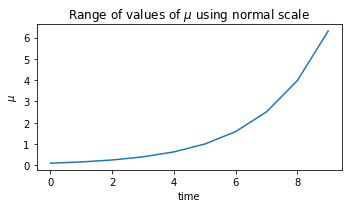

In [8]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(mu)
ax.set_title('Range of values of $\mu$ using normal scale')
ax.set_ylabel('$\mu$')
ax.set_xlabel('time')
fig.tight_layout()

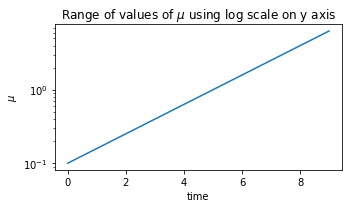

In [9]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.semilogy(mu)
ax.set_title('Range of values of $\mu$ using log scale on y axis')
ax.set_ylabel('$\mu$')
ax.set_xlabel('time')
fig.tight_layout()

### Residual matrix
The residual matrix is defined as

\begin{equation}
R = \left[r_1 \dots r_k \right]
\end{equation}

where $r_k = x_{k+1} - x_k$.

It can be also computed as
\begin{equation}
R = X_{ss} - X_{ii}
\end{equation}

where $X_{ss} = [ x_2 \dots x_{k+1}]$ and $X_{ii} = [ x_1 \dots x_k]$.

In [10]:
# compute residual matrix

R_cycle = []

for j in range(1,k+1):
    R_cycle.append(x_list[:,j+1]-x_list[:,j])

R_cycle = np.transpose(np.matrix(R_cycle))

x_ii = x_list[:,1:k+1] # samples from x_1 rto x_k
x_ss = x_list[:,2:k+2] # samples from x_2 to x_(k+1)
R = np.matrix(x_ss-x_ii)
print("Dimension of R: {0}".format(R.shape))

print("Norm of the difference between R computed with for cycle and with matrices: {0}".format(np.linalg.norm(R_cycle - R)))

Dimension of R: (60, 10)
Norm of the difference between R computed with for cycle and with matrices: 0.0


The matrix $M$ is given by
\begin{equation}
M = R^{T} R
\end{equation}

In the paper, $M$ is defined as 
\begin{equation}
M = \dfrac{R^{T}R}{\| R^{T} R \|}
\end{equation}
but since it derives from the gradient of $\| Rc \|^2 + \mu \| c \|^{2}$, I think it should not be normalized.

In [11]:
# compute and normalize the matrix M

M = np.matmul(np.transpose(R), R)
M = M/np.linalg.norm(M, ord='fro')

print("Dimension of M: {0}".format(M.shape))

Dimension of M: (10, 10)


For each $\mu_{i}$, solve $(M+\mu_{i} I)z = e$ with respect to $z$ and normalize the solution, obtaining $c_{\mu_{i}}$.
This means that, in case a unique solution exists, it is given by
\begin{equation}
c_{\mu_{i}} = \dfrac{(M+\mu_{i} I)^{-1}}{\| (M+\mu_{i} I)^{-1} \|}.
\end{equation}
Then, $x_{\mu_{j}}$ is computed as
\begin{equation}
x_{\text{extr}}(\mu_{i}) = \sum_{j=0}^{k} c_{\mu_{i,j}} x_{j}.
\end{equation}
Alternatively, it can be computed as
\begin{equation}
x_{\text{extr}}(\mu_{i}) = X' c_{\mu_{i,j}}
\end{equation}
where $X'=[x_0 \dots x_k]$.

In [12]:
for i in range(k):
    a = M+mu[i]*np.eye(M.shape[0])
    #print(a.shape)
    b = np.ones(M.shape[0])
    #print(b.shape)
    c = np.linalg.solve(a, b)
    #print(c.shape)
    c = c/np.linalg.norm(c)
    #print(c.shape)
    x_extr = np.zeros(m)
    for j in range(k):
        x_extr = x_extr + c[j]*x_list[:,j]
    x_extr = np.array(x_extr)
    x_extr2 = np.matmul(x_list[:,0:k], c)
    x_extr2 = np.transpose(x_extr2)
    
print("Norm of the difference between x_extr computed in the two possible ways: {0}".format(np.linalg.norm(x_extr2-x_extr)))

Norm of the difference between x_extr computed in the two possible ways: 2.718346558227068e-15


### Extrapolation step

The value $x_{extr}^{*}$ is chosen as the solution of

\begin{equation}
\min_{\mu_{j}, j=1,\dots,k} x_{extr}(\mu_{j}).
\end{equation}


In [13]:
#print(x_list[:,0].shape)
x0 = x_list[:,0]

f_star = f(x0)
x_star = x0

print("Initial value of f_star: {0}".format(f_star))

for i in range(k):
    a = M+mu[i]*np.eye(M.shape[0])
    #print(a.shape)
    b = np.ones(M.shape[0])
    #print(b.shape)
    c = np.linalg.solve(a, b)
    #print(c.shape)
    #c = np.sum(np.linalg.inv(M+mu[i]*np.eye(M.shape[0])),0)
    c = c/np.linalg.norm(c)
    x_extr = np.matmul(c, np.transpose(x_list[:,0:k]))
    x_extr = np.array(x_extr)
    #print(x_extr)
    
    f_extr = f(x_extr)
    if(f_extr < f_star):
        f_star = f_extr
        x_star = x_extr
        
print("Final value of f_star: {0}".format(f_star))

Initial value of f_star: 88.53524970537624
Final value of f_star: 67.67657432285499


### Final output

The final output is chosen as
\begin{equation}
x_{0} + t(x_{extr}^{*} - x_{0})
\end{equation}

where $t$ is initialized to 1 and doubled while $F(2t)< F(t)$, where $F(t) = f(x_{0} + t(x_{extr}^{*} - x_{0}))$.

In [14]:
t = 1

F = lambda t : f(x0 + t*(x_star-x0))

print("Initial value F(1) (must be f(x_star)): {0}".format(F(t)))

while(F(2*t) < F(t)):
    t = 2*t

x_hat = x0 + t*(x_star-x0)

print("Value of the objective function: {0}".format(f(x_hat)))

Initial value F(1) (must be f(x_star)): 67.67657432285499
Value of the objective function: 67.67657432285499


### Complete algorithm

In [15]:
def nonlinear_acc(x_list, f, mu_min, mu_max):
    k = x_list.shape[1] - 2
    log_step = np.log(mu_max/mu_min)/(k+1)
    log_mu = np.arange(np.log(mu_min), np.log(mu_max), log_step)
    mu = np.exp(log_mu)
    
    # Compute the residue matrix
    x_ii = x_list[:, 1:k+1] # samples from x_1 rto x_k
    x_ss = x_list[:,2:k+2] # samples from x_2 to x_(k+1)
    R = np.matrix(x_ss-x_ii)
    M = np.matmul(np.transpose(R), R)
    M = M/np.linalg.norm(M, ord='fro')
    
    # Find x_star
    x0 = x_list[:,0]
    f_star = f(x0)
    x_star = x0

    for i in range(k+1):
        a = M+mu[i]*np.eye(M.shape[0]) # a is symmetric
        b = np.ones(M.shape[0])
        c = np.linalg.solve(a, b)
        c = c/np.linalg.norm(c)
        x_extr = np.matmul(c, np.transpose(x_list[:,0:k]))
        x_extr = np.array(x_extr)

        f_extr = f(x_extr)
        if(f_extr < f_star):
            f_star = f_extr
            x_star = x_extr
    
    
    # find the best value of t that minimizes f(x0 + t*(x_star-x0))
    t = 1
    F = lambda t : f(x0 + t*(x_star-x0))
    while(F(2*t) < F(t)):
        t = 2*t

    x_hat = x0 + t*(x_star-x0)
    
    return x_hat    

In [16]:
x_hat = nonlinear_acc(x_list, f, mu_min, mu_max)
print("Value of the objective function: {0}".format(f(x_hat)))

Value of the objective function: 67.67597341029817
